In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.feature_selection import chi2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import ttest_ind
from tabulate import tabulate

# from dtreeviz.trees import dtreeviz

sns.set(style='white', context='notebook', palette='deep')
pd.set_option('display.max_columns', None)
np.random.seed(2)

In [2]:
random_seed = 2
y_type = 'NSP'

In [3]:
df_data = pd.read_excel('CTG.xlsx', sheet_name="Data", header=1)
df_data = df_data[0:-3]
df_data=df_data.set_index(np.arange(2126)+1)

df = pd.read_excel('CTG.xlsx', sheet_name="Raw Data")
df = df[1:-3] # delete empty rows
df = df.drop(['FileName'], axis=1) # delete FileName column
df = df.drop(['SegFile'], axis=1) # delete SegFile column
df = df.drop(['LBE'], axis=1) # delete LBE column (repeated LB column)
df = df.drop(['DR'], axis=1) # delete DR column (everything is zero)
a= df_data['AC.1']
df['AC'] = df_data['AC.1']
df['FM'] = df_data['FM.1']
df['UC'] = df_data['UC.1']
df['DL'] = df_data['DL.1']
df['DS'] = df_data['DS.1']
df['DP'] = df_data['DP.1']

df = df[['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV',  'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 
         'Median', 'Variance', 'Tendency', 'CLASS', 'NSP']]

df['Nmax'] = df['Nmax'].astype(int)
df['Nzeros'] = df['Nzeros'].astype(int)
df['CLASS'] = df['CLASS'].astype(int)
df['NSP'] = df['NSP'].astype(int)

In [4]:
X = df.drop(['CLASS','NSP'],axis=1)
y = df[y_type]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)

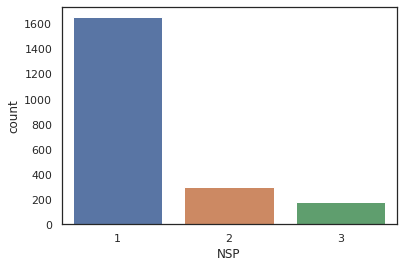

In [5]:
g = sns.countplot(x=y)

## Chi 2

In [6]:
X_edit = X.copy()
X_edit['Tendency'] += 1 # ponieważ Tendency to -1 lub 0 lub 1, a test chi_2 nie akceptuje ujemnych liczb

In [7]:
chi_scores = chi2(X_edit,y)
chi_2 = pd.Series(chi_scores[0],index = X_edit.columns)
chi_2.sort_values(ascending = False , inplace = True)
df_chi = pd.DataFrame(data={'Cecha': chi_2.index, 'Wartosc': chi_2.values})
df_chi['Cecha str'] = [str(int) for int in chi_2.index]
df_chi[['Cecha','Wartosc']].head()

,Cecha,Wartosc
0,ALTV,17921.988734
1,Variance,11801.125508
2,ASTV,3270.412869
3,Width,2258.452116
4,Min,1508.513834


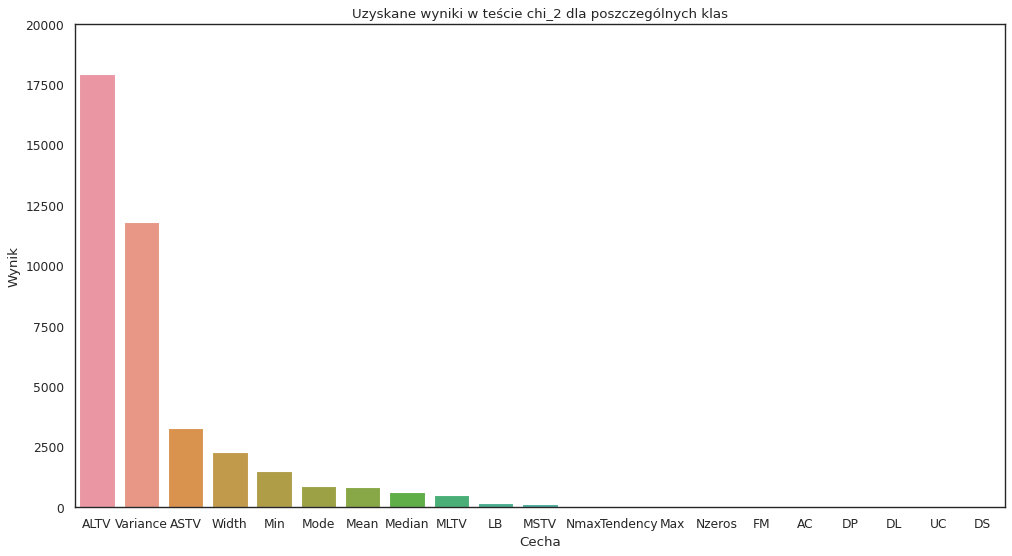

In [8]:
plt.figure(figsize=(15, 8), dpi=80)
plt.title('Uzyskane wyniki w teście chi_2 dla poszczególnych klas')
plt.ylim(0, 20000)
string_index = [str(int) for int in chi_2.index]
sns.barplot(y='Wartosc', x='Cecha str', data=df_chi);
plt.xlabel("Cecha")
plt.ylabel("Wynik")
plt.show()

In [9]:
def generate_u0(c,n):
    u0= []
    for i in range(c):
        u0.append([])
        for j in range(n):
            if i==j or i==j%c:
                u0[i].append(1)
            else:
                u0[i].append(0)
    return u0

In [10]:
def generate_vt(u, x, c, n, p, m):
    v=[]
    for i in range(c):
        v.append([])
        for j in range(p):
            v_ij=sum((u[i][k]**m)*x[k][j] for k in range(n))/sum(u[i][k]**m for k in range(n))
            v[i].append(v_ij)
    return v

In [11]:
def calculate_d(x,v, c, n):
    d=[]
    for i in range(c):
        d.append([])
        for k in range(n):           
            d[i].append(np.linalg.norm(abs(np.subtract(x[k],v[i]))))
    return d

In [12]:
def generate_u(d, m, c, n):
    d_eps = 1e-6
    u=[]
    for i in range(c):
        u.append([])
        for k in range(n):
            u_sum=0
            different=False
            for s in range(c):
                if d[s][k]==0:
                    d[s][k] += d_eps
                #     different=True
                #     break
                u_sum+=(d[i][k]/d[s][k])**(2/(m-1))
            if not different:
                u[i].append(1/u_sum)                  
    return u

In [13]:
def delta_u(u1, u2, c, n):
    return sum(sum(np.linalg.norm(np.subtract(u2[i][k], u1[i][k])) for k in range(n)) for i in range(c))

In [14]:
X

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
1,120.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2,0,120.0,137.0,121.0,73.0,1.0
2,132.0,0.006380,0.000000,0.006380,0.003190,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6,1,141.0,136.0,140.0,12.0,0.0
3,133.0,0.003322,0.000000,0.008306,0.003322,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5,1,141.0,135.0,138.0,13.0,0.0
4,134.0,0.002561,0.000000,0.007682,0.002561,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11,0,137.0,134.0,137.0,13.0,1.0
5,132.0,0.006515,0.000000,0.008143,0.000000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9,0,137.0,136.0,138.0,11.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2122,140.0,0.000000,0.000000,0.007426,0.000000,0.0,0.0,79.0,0.2,25.0,7.2,40.0,137.0,177.0,4,0,153.0,150.0,152.0,2.0,0.0
2123,140.0,0.000775,0.000000,0.006971,0.000000,0.0,0.0,78.0,0.4,22.0,7.1,66.0,103.0,169.0,6,0,152.0,148.0,151.0,3.0,1.0
2124,140.0,0.000980,0.000000,0.006863,0.000000,0.0,0.0,79.0,0.4,20.0,6.1,67.0,103.0,170.0,5,0,153.0,148.0,152.0,4.0,1.0
2125,140.0,0.000679,0.000000,0.006110,0.000000,0.0,0.0,78.0,0.4,27.0,7.0,66.0,103.0,169.0,6,0,152.0,147.0,151.0,4.0,1.0


In [15]:
p=X.shape[1]
n=X.shape[0]
c=3
m=2
epsilon = 1e-5
d_u = 2*epsilon
u_old=generate_u0(c,n)
print(p,n)

21 2126


In [16]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,init='random').fit_transform(X)

In [17]:
import seaborn as sns
df_tsne = pd.DataFrame()
df_tsne['tsne-2d-one'] = X_embedded[:,0]
df_tsne['tsne-2d-two'] = X_embedded[:,1]
df_tsne['y'] = y

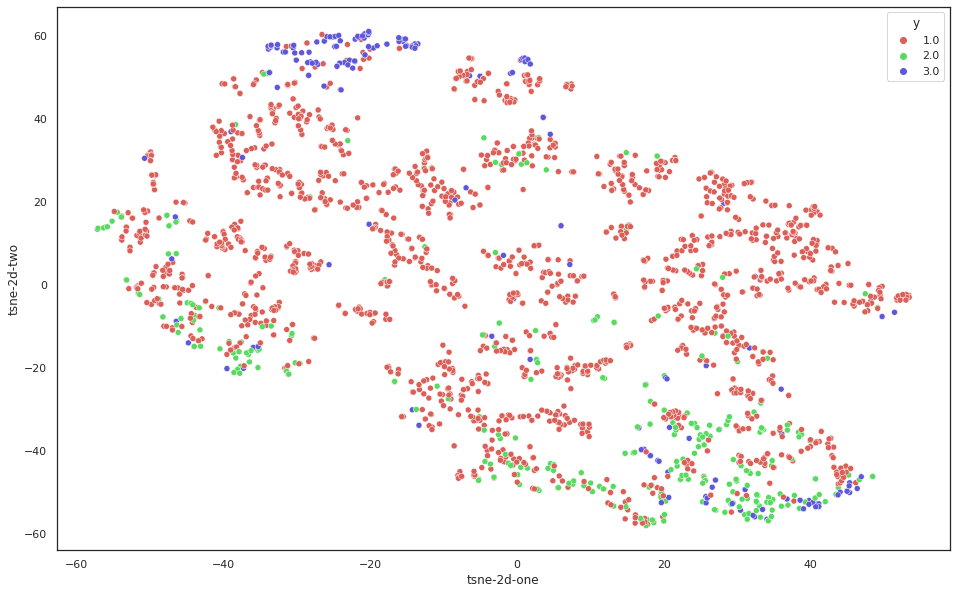

In [18]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 3),
    data=df_tsne,
    legend="full"
);

In [19]:
while epsilon<d_u:
    v = generate_vt(u_old,X,c,n,p,m)
    d = calculate_d(X,v,c,n)
    u_new = generate_u(d, m, c, n)
    d_u = delta_u(u_old, u_new, c, n)
    u_old = u_new
    print(d_u)

KeyError: 0